In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
import os
import glob
import tensorflow as tf
import numpy as np
from keras import layers, models, optimizers, losses, metrics, regularizers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K 
from keras.engine.topology import Container


/home/andrey/anaconda3/envs/nn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [5]:
from tensorflow.python import debug as tf_debug

sess = K.get_session()
sess.as_default()

In [7]:
from keras.datasets import mnist

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 13s 1us/step


In [9]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

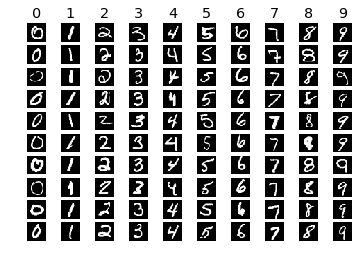

In [10]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [26]:
def build_encoder():
    
    img_input = layers.Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(32, kernel_size=4, strides=2, padding='same')(img_input)
    x = layers.ELU()(x)
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    x = layers.ELU()(x)
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.ELU()(x)

    output = layers.GlobalAveragePooling2D()(x)
    
    return models.Model(img_input, output, 
                        name='encoder')

In [34]:
def build_decoder():
    
    emb_input = layers.Input(shape=(128,))
    
    x = layers.Dense(784)(emb_input)
    x = layers.ELU()(x)
    x = layers.Reshape((7,7,16))(x)
    
#     Блок убирает шахматную доску
#     x = layers.UpSampling2D()(x)
#     x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')
    
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.ELU()(x)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.ELU()(x)
    x = layers.Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
    
    return models.Model(emb_input, x, 
                        name='decoder')

In [35]:
def build_autoencoder():
    img_input = layers.Input(shape=(28, 28, 1))
    encoder = build_encoder()
    decoder = build_decoder()
    
    embedding = encoder(img_input)
    reconstructed_input = decoder(embedding)
    
    return models.Model(img_input, reconstructed_input, 
                        name='autoencoder')

In [36]:
K.clear_session()
model = build_autoencoder()

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 128)               164576    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         194065    
Total params: 358,641
Trainable params: 358,641
Non-trainable params: 0
_________________________________________________________________


Тренировочный цикл

In [38]:
model.compile('adam', 'mae')

In [39]:
x_train = np.expand_dims(x_train, -1)

In [40]:
model.fit(x=x_train, callbacks= [ReduceLROnPlateau(patience=4, monitor='loss', epsilon=1)],
          y=x_train, 
          batch_size=128, 
          epochs=3)

Epoch 1/3
60000/60000 [==============================] - 473s 8ms/step - loss: 15.2276
Epoch 2/3
60000/60000 [==============================] - 495s 8ms/step - loss: 7.3736
Epoch 3/3
60000/60000 [==============================] - 475s 8ms/step - loss: 6.2644


In [41]:
output = model.predict(np.expand_dims(x_test, -1), batch_size=128)

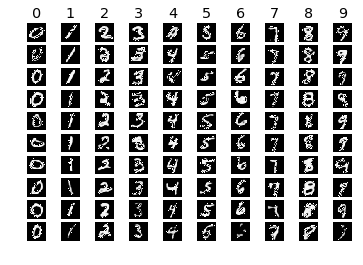

In [44]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(np.squeeze(output[idx]).astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

---

### Seam Net Part

In [72]:
def build_seamnet():
    img_true = layers.Input(shape=(28, 28, 1))
    img_false = layers.Input(shape=(28, 28, 1))
    
    encoder = build_encoder()
    
    embedding_one = encoder(img_true)
    embedding_two = encoder(img_false)
    
    output = layers.dot([embedding_one, embedding_two], axes=-1, normalize=True)
    
    return models.Model([img_true, img_false], output, 
                        name='autoencoder')

In [73]:
model = build_seamnet()

In [74]:
model.compile('adam', 'mae')

In [75]:
x_train = np.expand_dims(x_train, -1)

In [76]:
def generate_batch(data, labels, batch_size):
    indexes = np.arange(len(data))
    
    while True:
        batch_obj = []
        batch_pair_obj = []
        batch_label = []
        for _ in range(batch_size // 2):
            class_index = np.random.choice(labels, 1, replace=False)

            class_objects_indexes = indexes[labels == class_index]
            object_index, positive_index = np.random.choice(class_objects_indexes, 2, replace=False)
            

            batch_obj.append(data[object_index])
            batch_pair_obj.append(data[positive_index])
            batch_label.append(1)

            other_objects_indexes = indexes[labels != class_index]
            negative_index = np.random.choice(other_objects_indexes, 1, replace=False)

            batch_obj.append(data[object_index])
            batch_pair_obj.append(data[negative_index[0]])
            batch_label.append(-1)

        yield [np.expand_dims(batch_obj, -1), np.expand_dims(batch_pair_obj, -1)], np.array(batch_label)

In [77]:
generator = generate_batch(x_train, y_train, 128)

In [78]:
model.fit_generator(generator=generator, 
                    steps_per_epoch= 100, 
                    epochs=4, 
                    validation_steps= 32, 
                    callbacks= [ReduceLROnPlateau(patience=6, monitor='loss', epsilon=0.01, verbose=1)])

Epoch 1/4


ValueError: Error when checking input: expected input_10 to have 4 dimensions, but got array with shape (128, 28, 28, 1, 1, 1, 1, 1)